# Sampling from the generative model 

In this notebook, we will use the generative model of the HDHP (Hierarchical Dirichlet-Hawkes Process) in order to sample events. We will start with a predifined number of users, say `10`, and we will attempt to model their behavior as they are posting questions in an online platform. For simplicity, our "vocabulary" will be dummy.

We start by importing all the libraries that will be required.

In [1]:
%matplotlib inline
import datetime
import string
import hdhp
import notebook_helpers
import seaborn as sns

Now, let us set some parameters for our model. These fall under two categories; the ones relevant to the content and then ones relevant to the time dynamics. Starting with the first set, we need  to decide on:

* the vocabulary: a dummy set of `100` words, i.e. `word0`, `word1`, ... , `word99`.
* the minimum and maximum length of a question
* the number of words of each pattern

As far as the time dynamics is concerned, we need to set:

* $\alpha_0$: the parameters of the Gamma prior for the time kernel of each pattern
* $\mu_0$: the parameters of the Gamma prior for the user activity rate
* $\omega$: the time decay parameter

Finally, in order to make the generative process more user-friendly, we can pre-set the number of patterns that our users can sample from.

In [2]:
vocabulary = ['word' + str(i) for i in range(100)]  # the `words` of our documents
doc_min_length = 5
doc_length = 10
words_per_pattern = 50

alpha_0 = (2.5, 0.75)
mu_0 = (2, 0.5)
omega = 3.5

num_patterns = 10

process = hdhp.HDHProcess(num_patterns=num_patterns, alpha_0=alpha_0,
                          mu_0=mu_0, vocabulary=vocabulary,
                          omega=omega, words_per_pattern=words_per_pattern,
                          random_state=12)

Before generating any questions, we can take a look at the patterns that we initialized our process with, and look at the content distribution of each pattern. Although each pattern has a different word distribution, we can still plot the overlap (Jaccard similarity) between the words that have non-zero probability for each pattern. Since we used a limited number of patterns, the distribution of the overlap will not be smooth.

Average overlap: 0.338826769742


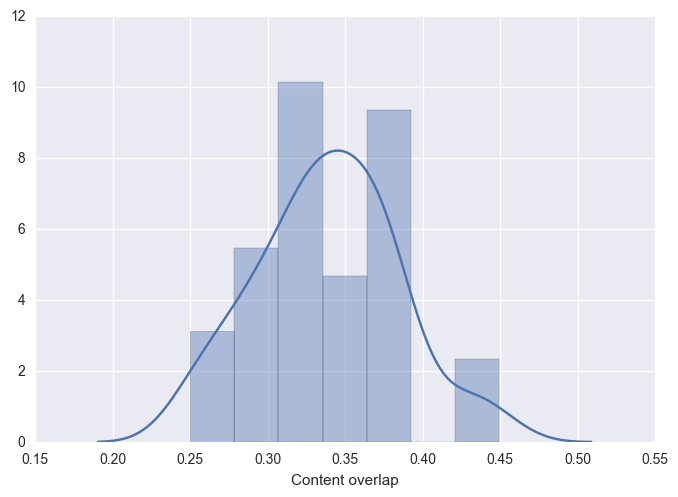

In [3]:
overlap = notebook_helpers.compute_pattern_overlap(process)
sns.distplot(overlap, kde=True, norm_hist=True, axlabel='Content overlap')

Now, the next step is to generate the questions for the users. As we mentioned above, for the purpose of this notebook, we will limit ourselves to a set of `10` users. For each of them, we will sample their questions from the process. We will sample at least `100` and at max `5000` questions per user, and we will make sure that we do not sample for more than `365` time units (assume that 1 time unit = 1 day).

In [4]:
process.reset()  # removes any previously generated data
for i in range(10):
    _= process.sample_user_events(min_num_events=100, 
                                  max_num_events=5000,
                                  t_max=365)
print 'Total #events', len(process.events)

Total #events 11862


We can now review which patterns each user has adopted and check the content distribution of one of these patterns.

In [5]:
print process.user_patterns_set(user=0)

[0, 1, 2, 3, 4, 6, 7, 8, 9]


In [6]:
print process.user_pattern_history_str(user=0, 
                                       patterns=[0, 1], 
                                       show_time=True)

 39.7 pattern= 1 task= 13 (u=0)  word8 word9 word9 word9 word11 word11 word12 word12 word12 word13 word23 word25 word29 word31 word41 word41 word47 word60 word63 word67 word86 word88 word94
 54.8 pattern= 1 task= 17 (u=0)  word11 word13 word27 word41 word41 word47 word53 word57 word65 word69 word86 word88 word90
   55 pattern= 1 task= 17 (u=0)  word18 word24 word41 word51 word88 word93 word96
  132 pattern= 1 task= 23 (u=0)  word8 word8 word9 word9 word18 word24 word29 word41 word41 word58 word81 word82 word88 word88 word94
  132 pattern= 1 task= 23 (u=0)  word7 word9 word12 word12 word12 word13 word25 word27 word41 word47 word47 word47 word61 word67 word88 word88 word88 word90 word96 word96 word96 word97
  198 pattern= 1 task= 39 (u=0)  word9 word12 word13 word18 word21 word24 word25 word32 word41 word47 word53 word74 word81 word90
  272 pattern= 0 task= 64 (u=0)  word8 word23 word39 word66 word71 word72 word83 word85
  282 pattern= 1 task= 68 (u=0)  word51 word51 word67 word81 word88

In [7]:
print process.pattern_content_str(patterns=[0, 1],
                                  show_words=10)

___Pattern 0___ 
word12 : 118
word24 : 82
word61 : 81
word42 : 67
word15 : 65
word8 : 62
word85 : 60
word87 : 57
word99 : 55
word36 : 54


___Pattern 1___ 
word41 : 147
word96 : 122
word53 : 117
word9 : 116
word31 : 106
word73 : 102
word47 : 100
word67 : 90
word94 : 86
word24 : 86



The last step is to plot the intensity (the rate at which each user asks questions) for each user and each pattern. Below, the plots share the same $y$-axis, so that the user intensities are comparable. Each color corresponds to a single pattern. We will also manually set the "beginning of time" at an arbitrary date.

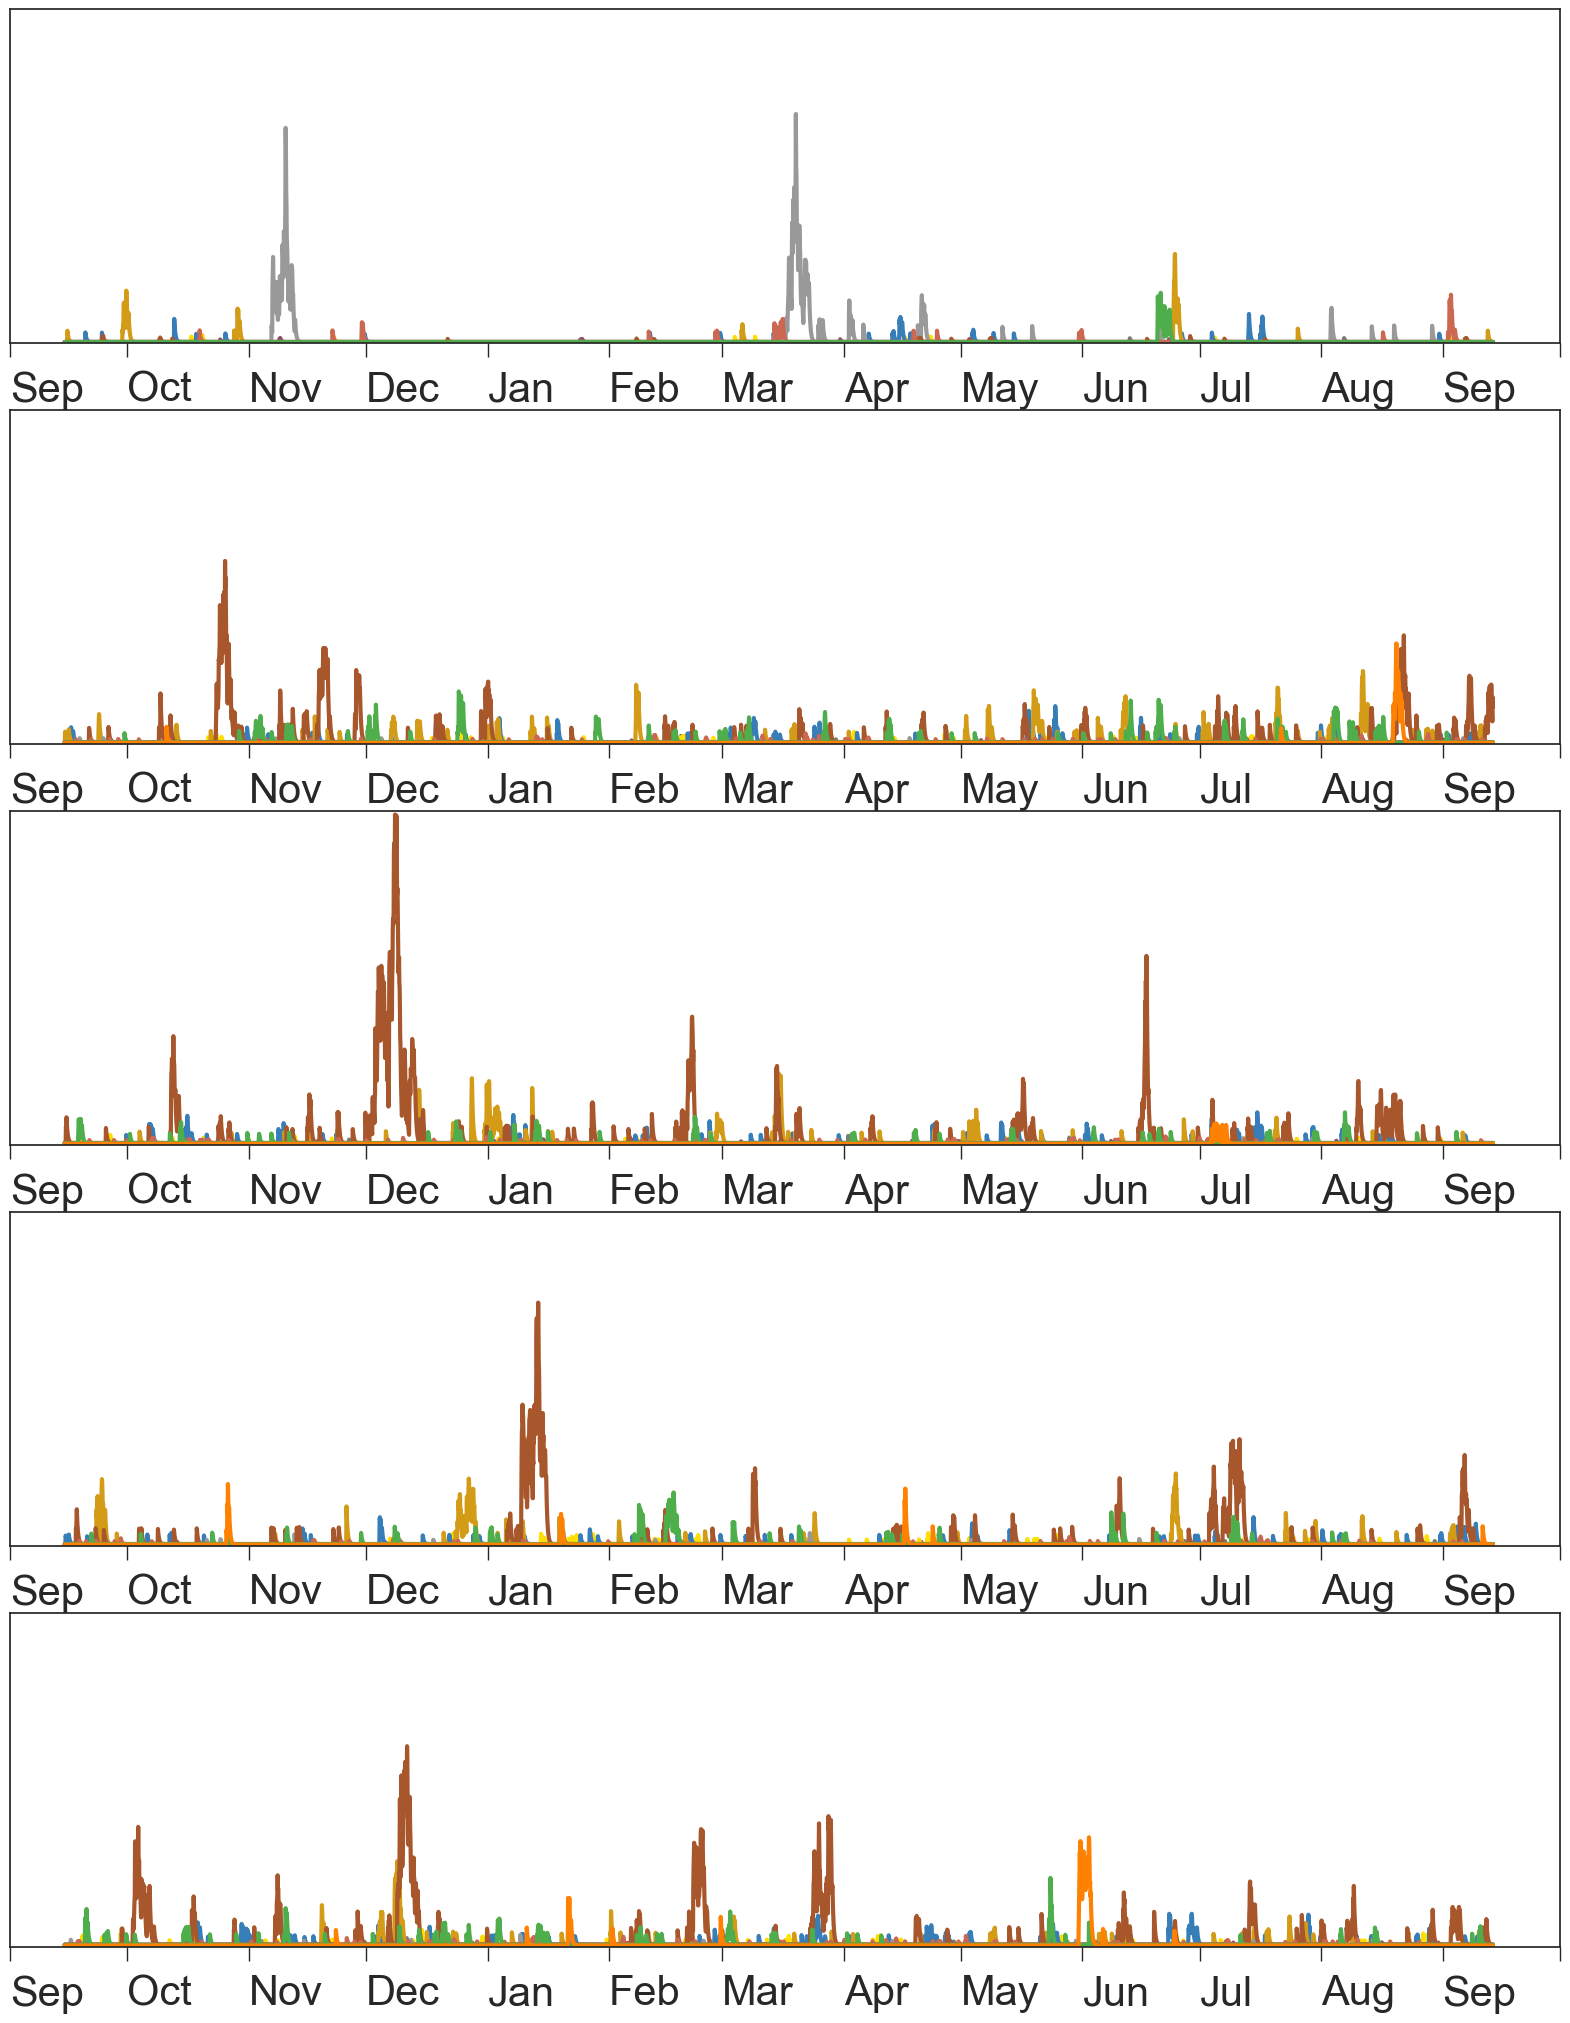

In [8]:
start_date = datetime.datetime(2015, 9, 15)
fig = process.plot(start_date=start_date, user_limit=5,
                   num_samples=5000, time_unit='days',
                   label_every=1, seed=5)